# CNN for Food and Non-Food Classifier
By: Reza Yogaswara
____

In [7]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import livelossplot
%matplotlib inline
plot_losses = livelossplot.PlotLossesKeras()

Using TensorFlow backend.


NameError: ignored

In [6]:
train_path = '%straining/' %PATH
valid_path = '%svalidation/' %PATH
test_path = '%sevaluation/' %PATH

classes = ('food', 'non-food')

print (train_path)

./drive/ColabNotebooks/Riset4PaperKM/Food-5K/training/


In [7]:
train_batches = ImageDataGenerator(rescale = 1./255, shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224), 
        class_mode='binary', batch_size=32)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size=(224,224), 
        class_mode='binary', batch_size=16)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), 
        class_mode='binary', batch_size=16)

nb_train_samples = 3001
nb_validation_samples = 1000

Found 3001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


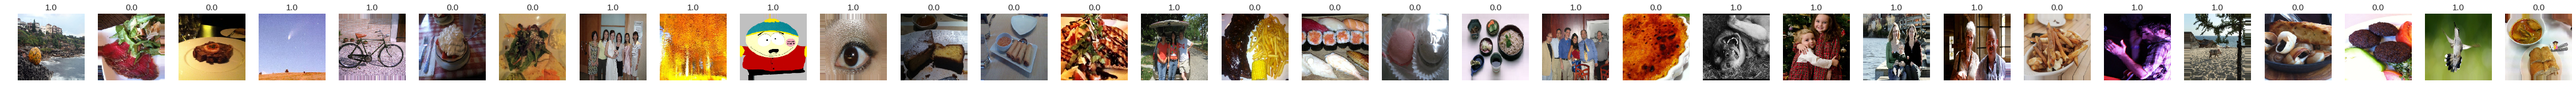

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(80,60), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        #print(ims[0])
        #ims = np.array(ims).astype(np.uint8)
        #print(ims)
        
        if (ims.shape[-1] != 3):
            ims = ims.transpose((1,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=15)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

# Build and train CNN

In [9]:
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_conv = 0.2                # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5              # drop probability for dropout @ fc layer

# Convolutional model
model = Sequential()

#initializer = initializers.random_normal(stddev=0.02)
initializer = 'normal'

# conv1 layer
model.add(Conv2D(100, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=pool_size ))
#model.add(Dropout(prob_drop_conv))

# conv2 layer
model.add(Conv2D(200, (3, 3), activation='relu', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=pool_size))
#model.add(Dropout(prob_drop_conv))

# conv3 layer
model.add(Conv2D(300, (3, 3), activation='relu', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=pool_size ))
model.add(Flatten())
#model.add(Dropout(prob_drop_conv))

# fc1 layer
model.add(Dense(500, activation='relu', kernel_initializer=initializer))
model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(10, activation='relu', kernel_initializer=initializer))
model.add(Dropout(prob_drop_hidden))

# fc3 layer
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 100)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 200)     180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 300)       540300    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 300)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 202800)            0         
__________

In [10]:
# Vizualizing model structure

sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
              Conv2D    \|/  -------------------      2800     0.0%
                relu   #####    222  222  100
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    111  111  100
              Conv2D    \|/  -------------------    180200     0.2%
                relu   #####    109  109  200
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     54   54  200
              Conv2D    \|/  -------------------    540300     0.5%
                relu   #####     52   52  300
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     26   26  300
             Flatten   ||||| -------------------         0     0.0%
                       #####      202800
               Dense   XXXXX ------------------- 101400500    99.3%
                rel

In [0]:
#model.compile(Adadelta(), loss='binary_crossentropy', metrics=['accuracy', 'mean_squared_error'])
model.compile(RMSprop(), loss='binary_crossentropy', metrics=['accuracy', 'mean_squared_error'])
#model.compile(SGD(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mean_squared_error'])

In [12]:
'''
history = model.fit_generator(train_batches, steps_per_epoch=32, #steps_per_epoch=nb_train_samples, 
                         callbacks=[plot_losses],
                              validation_steps = 32,
                    validation_data=valid_batches, epochs=50, verbose=2)
'''

batch_size = 32
epochs = 20

history = model.fit_generator(train_batches,
                         steps_per_epoch = batch_size,
                         epochs = epochs,
                         callbacks=[plot_losses],
                         validation_data = valid_batches,
                                  verbose = 1)


Epoch 1/20
 2/32 [>.............................] - ETA: 12:14 - loss: 1.1828 - acc: 0.4375 - mean_squared_error: 0.3478

KeyboardInterrupt: ignored

In [13]:
# Evaluate
x_test, y_test = valid_batches[0]
evaluation = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

16/16 [==============================] - 0s 8ms/step
Summary: Loss over the test dataset: 0.61, Accuracy: 0.69


dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error'])


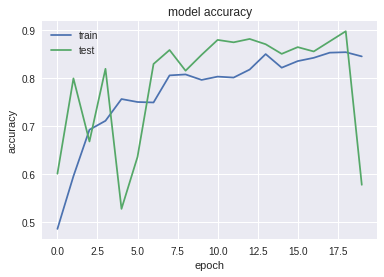

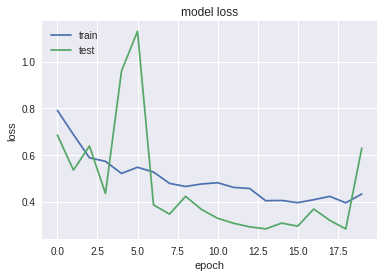

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.evaluate_generator(valid_batches, nb_validation_samples)

[0.6287250888888122, 0.5775188916876575, 0.21097465661408318]